In [40]:
import numpy as np
import pandas as pd
import pickle
import json
import seaborn as sb
from collections import defaultdict
import sys
import chardet
import matplotlib.pyplot as plt
%matplotlib inline

# Distribution of predictability values

In [41]:
def read_in_pred_files(pred_map_filepaths):
    pos_pred_maps = dict()
    for predictor, filepath in pred_map_filepaths.items():
        with open(filepath) as f:
            pos_pred_maps[predictor]=json.load(f)
    return pos_pred_maps

In [42]:
import re
def pre_process_string(string, remove_punctuation=True, all_lowercase=True, strip_spaces=True):

    if remove_punctuation:
        string = re.sub(r'[^\w\s]', '', string)
        # string = string.strip(punctuation)
    if all_lowercase:
        string = string.lower()
    if strip_spaces:
        string = string.strip()
    return string

In [43]:
def text_words_predictions(pos_pred_map,predictor):
    
    pred_values = defaultdict(list)
    
    for text, words in pos_pred_map.items():
        for word, predictions in words.items():
            pred_value = 0.0
            target = pre_process_string(predictions['target'])
            if target in predictions['predictions'].keys():
                pred_value = predictions['predictions'][target]
            if pred_value <= 1: # to exclude mistaken value from cloze data: 1.025
                pred_values['text_word'].append(target)
                pred_values['prediction'].append(pred_value)
                pred_values['predictor'].append(predictor)
                
    return pred_values

In [44]:
# read in predictions
pred_map_filepaths = {'cloze':'../data/processed/prediction_map_Provo_Corpus_cloze_continuous_reading_english.json',
                      'GPT2': '../data/processed/prediction_map_Provo_Corpus_gpt2_continuous_reading_english_topkall.json',
                      'LLAMA': '../data/processed/prediction_map_Provo_Corpus_llama_continuous_reading_english_topkall.json'}
pred_maps = read_in_pred_files(pred_map_filepaths)

In [47]:
def compute_frequency_predictions(predictions):
    
    pred_values, counts, predictors, proportion = [],[],[],[]
    
    for predictor in set(predictions['predictor']):
        pred_value_counts = defaultdict(int)
        for prediction, a_predictor in zip(predictions['prediction'],predictions['predictor']):
            if predictor == a_predictor:
                pred_value_counts[prediction] += 1
        pred_values.extend(pred_value_counts.keys())
        counts.extend(pred_value_counts.values())
        proportion.extend([value/sum(counts) for value in pred_value_counts.values()])

        for pred_value in range(len(pred_value_counts.keys())): 
            predictors.append(predictor)

        assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors))

    pred_value_counts_col = {'predictability': pred_values,
                             'counts': counts,
                             'proportion': proportion,
                             'predictor': predictors}
    return pred_value_counts_col

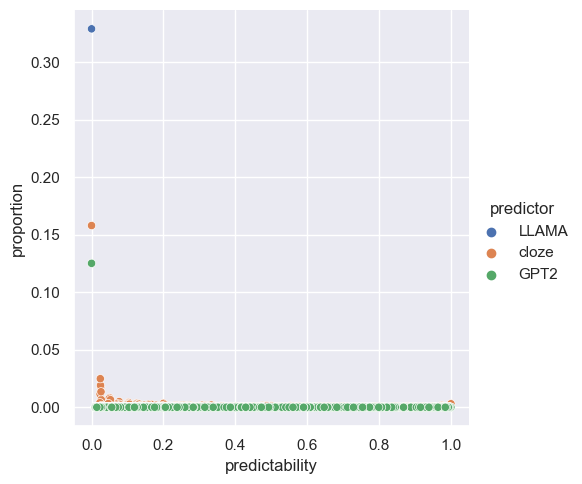

In [49]:
# count pred values in each predictor only including the predictability of target words (words in text)
pred_value_counts_col = compute_frequency_predictions(target_predictions)
pred_value_counts_df = pd.DataFrame.from_dict(pred_value_counts_col)
pred_value_counts_df.sort_values(by='predictability', ascending=True, inplace=True)
pred_value_counts_df.to_csv('../data/processed/predictions_distribution.csv',sep='\t', index=False)
sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'proportion', hue = 'predictor', kind = 'scatter')

In [ ]:
# proportion of unknown predicted tokens per target word in relation to model lexicon
unknown_map_filepaths = {'cloze': '../data/processed/prediction_map_Provo_Corpus_cloze_continuous_reading_english_unknown.json',
                         'GPT2': '../data/processed/prediction_map_Provo_Corpus_gpt2_continuous_reading_english_topkall_unknown.json',
                         'LLAMA': '../data/processed/prediction_map_Provo_Corpus_llama_continuous_reading_english_topkall_unknown.json'}

pred_maps_unknown = read_in_pred_files(unknown_map_filepaths)

predictors, proportion = [],[]

for predictor in pred_maps.keys():
    
    proportions = []
    
    for text, info in pred_maps_unknown[predictor].items():
        for pos, pos_info in info.items():
            unknown_predictions = pos_info['predictions']['token_preprocessed'].keys()
            all_predictions = pred_maps[predictor][text][pos]['predictions'].keys()
            if len(all_predictions) > 0:
                proportion_unknown = len(unknown_predictions)/len(all_predictions)
                proportions.append(proportion_unknown)
                
    proportion.append(sum(proportions)/len(proportions))
    predictors.append(predictor)
    
assert len(predictors) == len(proportion)

sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(x=predictors, y=proportion)
for i in ax.containers:
    ax.bar_label(i,)

In [53]:
# analyse unknown tokens predicted by language model
from collections import Counter

for predictor in ['GPT2', 'LLAMA']:
    pred_tokens = []
    for text, info in pred_maps_unknown[predictor].items():
        for pos, pos_info in info.items():
            pred_tokens.extend(pos_info['predictions'].keys())
    unknown_tokens = Counter(pred_tokens)
    df_unknown = pd.DataFrame({'TOKEN': [token for token in unknown_tokens.keys()], 'COUNT': [count for count in unknown_tokens.values()]})
    df_unknown = df_unknown.sort_values(by='COUNT',ascending=False)
    df_unknown.to_csv(f'../data/processed/unknown_counts_{predictor}.csv',sep='\t', index=False)

    df_unknown_short = pd.DataFrame({'TOKEN': [token for token in unknown_tokens.keys() if len(token) <= 2], 'COUNT': [count for token, count in unknown_tokens.items() if len(token) <= 2]})
    df_unknown_short = df_unknown_short.sort_values(by='COUNT',ascending=False)
    df_unknown_short.to_csv(f'../data/processed/unknown_short_counts_{predictor}.csv',sep='\t',index=False)

In [51]:
# check the average number of predictions from language model
for predictor in ['GPT2', 'LLAMA']:
    n_predictions = []
    for text, info in pred_maps[predictor].items():
        for pos, pos_info in info.items():
            predictions = pos_info['predictions'].keys()
            n_predictions.append(len(predictions))
    print('Average number of predictions: ', sum(n_predictions)/len(n_predictions))
    print('Range: ', min(n_predictions), '-',max(n_predictions))

Average number of predictions:  10.435105987355895
Range:  0 - 36
Average number of predictions:  9.792487913722573
Range:  0 - 26


In [ ]:
from transformers import GPT2Tokenizer, LlamaTokenizer
# check how many text words correspond to a multi-token in language mdel and thus are not in lexicon
for predictor in ['GPT2','LLAMA']:
    unknown = dict()
    total = 0
    if predictor == 'GPT2':
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    elif predictor == 'LLAMA':
        tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf", legacy=False)
    for text, info in pred_maps[predictor].items():
        for pos, pos_info in info.items():
            target_word = pos_info['target']
            target_token = tokenizer.encode(target_word, return_tensors='pt')
            print(target_token, [tokenizer.decode(token) for token in target_token[0]])
            if target_token.size(dim=1) > 1:
                 unknown[target_word] = target_token
            total += 1
    print(f'Unknown target words to {predictor}: ', len(unknown.keys())/total, '%')

# Word prediction accuracy

In [54]:
acc = []
for predictor, texts in pred_maps.items():
    for info in texts.values():
        for predictions in info.values():
            target = pre_process_string(predictions['target'])
            if target in predictions['predictions'].keys():
                acc.append(1)
            else: 
                acc.append(0)
    acc_score = sum(acc)/len(acc)
    print(f'{predictor} accuracy: {acc_score}')

cloze accuracy: 0.6841517857142857
GPT2 accuracy: 0.6544541565928956
LLAMA accuracy: 0.6600545499628069


In [64]:
# soft accuracy: if token matches the beginning of the target (for language models with subtokenization)
acc, preds, targets = [],[],[]
for predictor, texts in pred_maps.items():
    for info in texts.values():
        for predictions in info.values():
            score = 0
            target = pre_process_string(predictions['target'])
            for prediction in predictions['predictions'].keys():
                if prediction != '' and len(prediction) <= len(target) and prediction == target[:len(prediction)]:
                    score = 1
                    if prediction != target: # save the ones are not exactly the same for analysis
                        preds.append(prediction)
                        targets.append(target)
                    break
            acc.append(score)
    acc_score = sum(acc)/len(acc)
    print(f'{predictor} accuracy: {acc_score}')
    acc_df = pd.DataFrame({'prediction':preds,'target':targets})
    acc_df.to_csv(f'../data/processed/soft_accuracy_predictions_{predictor}.csv',sep='\t',index=False)

cloze accuracy: 0.7038690476190477
GPT2 accuracy: 0.6832806397619491
LLAMA accuracy: 0.7151004215224399


In [ ]:
# soft accuracy: tokenize target, if first token in predictions, acc = 1
from transformers import GPT2Tokenizer, LlamaTokenizer

for predictor in ['GPT2','LLAMA']:
    acc, preds, targets = [],[],[]
    for info in pred_maps[predictor].values():
        for predictions in info.values():
            target_tokens_ids = tokenizer.encode(predictions['target'], return_tensors='pt')
            target_tokens = [tokenizer.decode(token) for token in target_tokens_ids[0]]
            pos = 0
            score = 0
            if ' ' == target_tokens[pos]:
                pos = 1
            if pre_process_string(target_tokens[pos]) in predictions['predictions'].keys():
                score = 1
                preds.append(pre_process_string(target_tokens[pos]))
                targets.append(predictions['target'])
        acc.append(score)
    acc_score = sum(acc)/len(acc)
    print(f'{predictor} accuracy: {acc_score}')
    acc_df = pd.DataFrame({'prediction':preds,'target':targets})
    acc_df.to_csv(f'../data/processed/soft_accuracy_predictions_tokenizer_{predictor}.csv',sep='\t',index=False)

In [1]:
import pickle
# inspect lexicon
with open('../data/processed/lexicon.pkl', 'rb') as infile:
      lexicon = pickle.load(infile)
print(lexicon)

['shells', 'looking', 'south', 'decided', 'attractive', 'worth', 'lay', 'credit', 'britain', 'couldnt', 'cells', 'oblong', 'waiting', 'lets', 'thing', 'here', 'thinking', 'wave', 'day', 'finding', 'breather', 'walked', 'interestingly', 'comment', 'comes', 'girls', 're', 'islands', 'production', 'immigrants', 'industry', 'owners', 'united', 'technique', 'inhabited', 'join', 'much', 'longer', 'sky', 'improve', 'musicians', 'form', 'key', 'bussize', 'police', 'align', 'proton', 'paul', 'didnt', 'silence', 'am', 'lake', 'european', 'million', 'park', 'footprint', 'dollar', 'justice', 'declare', 'boston', 'hang', 'canny', 'stuffed', 'position', 'high', 'help', 'compact', 'google', 'eroded', 'oncoming', 'predator', 'history', 'levels', 'noxious', 'cos', 'witness', 'interpret', 'fulfilling', 'person', 'comprised', 'asked', 'than', 'incowned', 'everybody', 'feeling', 'yes', 'happening', 'them', 'mr', 'differently', 'stars', 'kind', 'since', 'see', 'try', 'boys', 'close', 'planet', 'chattering'